In [1]:
from astropy.io import fits

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

from scipy import fftpack
import pylab as py
import pyfits
#Download radialProfile from http://www.astrobetter.com/wiki/python_radial_profiles
import radialProfile

# Read fits file

In [4]:
imagefile='imageFiles/comp_XRT20161006_061228.4.fits'
hdulist = fits.open(imagefile)
hdulist.info()
prihdr = hdulist[0].header
xscale = hdulist[0].header['XSCALE']
yscale = hdulist[0].header['YSCALE']
xaxlabel = hdulist[0].header['CUNIT1']
yaxlabel = hdulist[0].header['CUNIT2']
prihdr

Filename: imageFiles/comp_XRT20161006_061228.4.fits
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU     257   (1024, 1024)   float32   


SIMPLE  =                    T / Written by IDL:  Tue Nov  8 21:36:34 2016      
BITPIX  =                  -32 /Real*4 (floating point)                         
NAXIS   =                    2 /                                                
NAXIS1  =                 1024 /                                                
NAXIS2  =                 1024 /                                                
DATE    = '2016-10-16T14:17:22.000' /                                           
DATE_RF0= '2016-10-16T14:17:22.000' /                                           
DATE_RF1= '2016-11-08T21:15:20.228' /                                           
SATELLIT=                   33 /                                                
TELESCOP= 'HINODE  '           /                                                
INSTRUME= 'XRT     '           /                                                
TIMESYS = 'UTC (TBR)'          /                                                
MDP_CLK =           33265510

# Get Image Data

In [2]:
scidata = hdulist[0].data

plt.imshow(scidata)
plt.show()
print("image size: ",scidata.shape)

NameError: name 'hdulist' is not defined

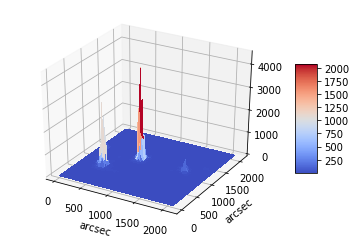

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')

xsize,ysize = scidata.shape;

# Make data.
X = np.arange(0, xscale*xsize, xscale)
Y = np.arange(0, yscale*ysize, yscale)
X, Y = np.meshgrid(X, Y)
Z = scidata

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.xlabel(xaxlabel)
plt.ylabel(yaxlabel)
plt.show()


# Time for Fourier Transform :D so exiting!

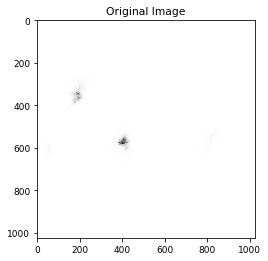

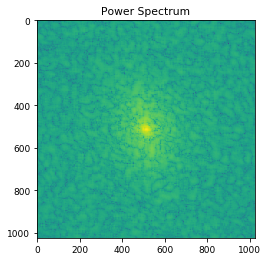

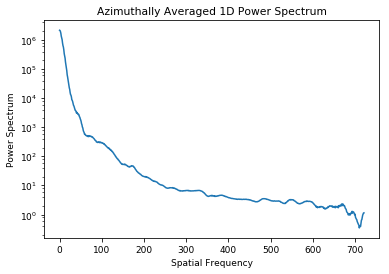

In [74]:
#image = pyfits.getdata(imagefile)
# Take the fourier transform of the image.

image = (scidata-np.mean(scidata))/np.max(scidata)
#image = scidata.astype(float)
F1 = fftpack.fft2(image)
 
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift(F1)
 
# Calculate a 2D power spectrum
psd2D = np.abs(F2)**2
 
# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)
 
# Now plot up both
py.figure(1)
py.clf()
py.title('Original Image')
py.imshow((image), cmap=py.cm.Greys)
 
py.figure(2)
py.clf()
py.imshow(np.log10(psd2D))
py.title('Power Spectrum')
 
py.figure(3)
py.clf()
py.semilogy(psd1D)
py.xlabel('Spatial Frequency')
py.ylabel('Power Spectrum')
py.title('Azimuthally Averaged 1D Power Spectrum')
 
py.show()

# Now Let's Begin Signal Processing

# Example 1: Local Histogram Equalization

This examples enhances an image with low contrast, using a method called local histogram equalization, which spreads out the most frequent intensity values in an image.

The equalized image has a roughly linear cumulative distribution function for each pixel neighborhood.

The local version of the histogram equalization emphasized every local graylevel variations.

From: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_local_equalize.html#sphx-glr-auto-examples-color-exposure-plot-local-equalize-py

/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


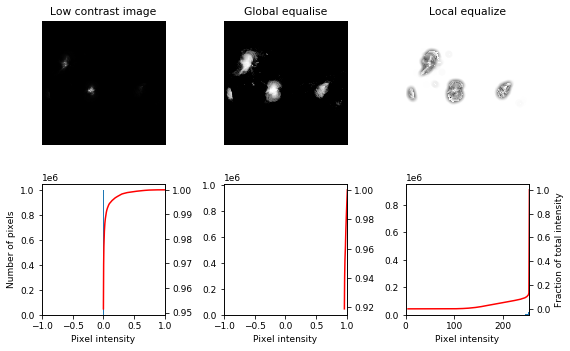

In [28]:
# Install: pip3 install scikit-image
from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
import matplotlib

matplotlib.rcParams['font.size'] = 9


def plot_img_and_hist(img, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(img, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(img.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[img.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Prepare data

#img = scidata
img = (scidata-np.mean(scidata))/np.max(scidata)
#img = img_as_ubyte(data.moon())

# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
selem = disk(30)
img_eq = rank.equalize(img, selem=selem)


# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1, adjustable='box-forced')
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0],
                         adjustable='box-forced')
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0],
                         adjustable='box-forced')
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()



Even more plots

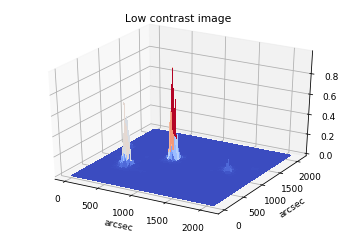

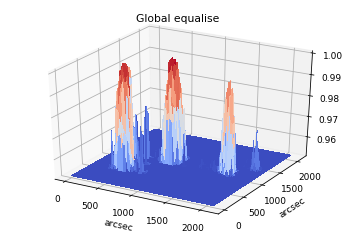

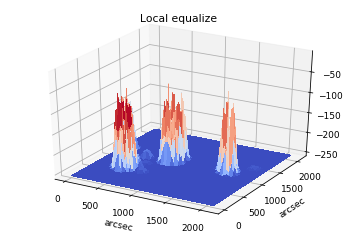

In [26]:
# Display results
# Plot the surface.
fig = plt.figure(1)
ax1 = fig.gca(projection='3d')
surf1 = ax1.plot_surface(X, Y, img, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#fig.colorbar(surf1, shrink=0.5, aspect=5)
ax1.set_title('Low contrast image')
plt.xlabel(xaxlabel)
plt.ylabel(yaxlabel)

plt.show()

fig = plt.figure(2)
ax2 = fig.gca(projection='3d')
surf2 = ax2.plot_surface(X, Y, img_rescale, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#fig.colorbar(surf2, shrink=0.5, aspect=5)
ax2.set_title('Global equalise')
plt.xlabel(xaxlabel)
plt.ylabel(yaxlabel)


fig = plt.figure(3)
ax2 = fig.gca(projection='3d')
surf2 = ax2.plot_surface(X, Y, img_eq*-1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
#fig.colorbar(surf2, shrink=0.5, aspect=5)
ax2.set_title('Local equalize')
plt.xlabel(xaxlabel)
plt.ylabel(yaxlabel)

plt.show()

Calculate Azimu

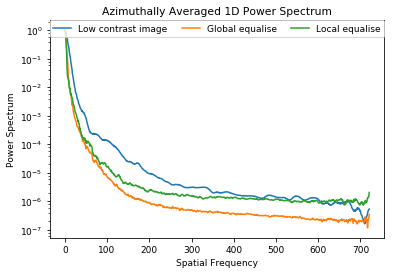

In [44]:
#Original Data
# Take the fourier transform of the image.

image1 = (scidata-np.mean(scidata))/np.max(scidata)
#image = scidata.astype(float)
F1 = fftpack.fft2(image1)
 
# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 2D fourier transformed image.
F2 = fftpack.fftshift(F1)
 
# Calculate a 2D power spectrum
psd2D = np.abs(F2)**2
 
# Calculate the azimuthally averaged 1D power spectrum
psd1D = radialProfile.azimuthalAverage(psd2D)


#------------------------------------------------------#
# Low contrast image LCI
LCI_F1 = fftpack.fft2(img)
LCI_F2 = fftpack.fftshift(LCI_F1)
LCI_psd2D = np.abs(LCI_F2)**2
LCI_psd1D = radialProfile.azimuthalAverage(LCI_psd2D)

#------------------------------------------------------#
# Global equalise GE

GI_F1 = fftpack.fft2(img_rescale)
GI_F2 = fftpack.fftshift(GI_F1)
GI_psd2D = np.abs(GI_F2)**2
GI_psd1D = radialProfile.azimuthalAverage(GI_psd2D)


#------------------------------------------------------#
# Local equalise LE

LE_F1 = fftpack.fft2(img_eq)
LE_F2 = fftpack.fftshift(LE_F1)
LE_psd2D = np.abs(LE_F2)**2
LE_psd1D = radialProfile.azimuthalAverage(LE_psd2D)

py.figure()
py.clf()
py.semilogy(LCI_psd1D/LCI_psd1D.max(), label='Low contrast image')
py.semilogy(GI_psd1D/GI_psd1D.max(), label='Global equalise')
py.semilogy(LE_psd1D/LE_psd1D.max(), label='Local equalise')
py.legend( loc=2,
           ncol=3, mode="expand", borderaxespad=0.)
py.xlabel('Spatial Frequency')
py.ylabel('Power Spectrum')
py.title('Azimuthally Averaged 1D Power Spectrum')
 
py.show()


# Example 2: Filtering regional maxima

From: http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_regional_maxima.html#sphx-glr-auto-examples-color-exposure-plot-regional-maxima-py

Here, we use morphological reconstruction to create a background image, 
which we can subtract from the original image to isolate bright features 
(regional maxima).

First we try reconstruction by dilation starting at the edges of the image. 
We initialize a seed image to the minimum intensity of the image, 
and set its border to be the pixel values in the original image. 
These maximal pixels will get dilated in order to reconstruct the background image.

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

# Convert to float: Important for subtraction later which won't work with uint8
#image = img_as_float(data.coins())
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

Subtracting the dilated image leaves an image with just the coins and a flat, 
black background, as shown below.

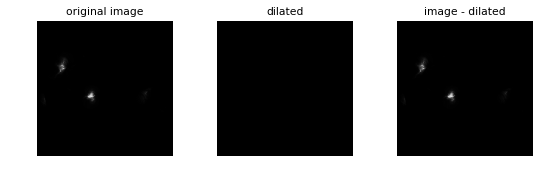

In [46]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')
ax0.set_adjustable('box-forced')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')
ax1.set_adjustable('box-forced')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')
ax2.set_adjustable('box-forced')

fig.tight_layout()
plt.show()